# Decision Tree models - NYC collisions dataset

import statements:

In [25]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from numpy import ndarray
from pandas import DataFrame, read_csv, unique
from matplotlib.pyplot import figure, subplots, savefig, show
from sklearn.tree import DecisionTreeClassifier
from ds_charts import plot_evaluation_results, multiple_line_chart
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

In [26]:
file_tag = 'NYC_collisions'
target = 'PERSON_INJURY'

## Dummified data without scaling:

get dataframes:

In [27]:
train: DataFrame = read_csv('data/train_sets/no_scaling.csv')
trnY: ndarray = train.pop(target).values
trnX: ndarray = train.values
labels = unique(trnY)
labels.sort()

test: DataFrame = read_csv('data/test_sets/no_scaling.csv')
tstY: ndarray = test.pop(target).values
tstX: ndarray = test.values

<Figure size 432x288 with 0 Axes>

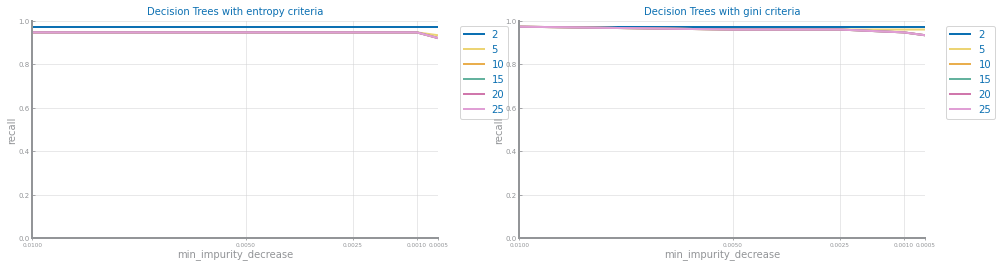

Best results achieved with entropy criteria, depth=2 and min_impurity_decrease=0.01 ==> recall=0.97


In [28]:
min_impurity_decrease = [0.01, 0.005, 0.0025, 0.001, 0.0005]
max_depths = [2, 5, 10, 15, 20, 25]
criteria = ['entropy', 'gini']
best = ('',  0, 0.0)
last_best = 0
best_model = None

figure()
fig, axs = subplots(1, 2, figsize=(16, 4), squeeze=False)
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    for d in max_depths:
        yvalues = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(trnX, trnY)
            prdY = tree.predict(tstX)
            yvalues.append(metrics.recall_score(tstY, prdY, pos_label='Killed'))
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_model = tree

        values[d] = yvalues
    multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title=f'Decision Trees with {f} criteria',
                           xlabel='min_impurity_decrease', ylabel='recall', percentage=True)
savefig(f'images/{file_tag}_dt_study.png')
show()
print('Best results achieved with %s criteria, depth=%d and min_impurity_decrease=%1.2f ==> recall=%1.2f'%(best[0], best[1], best[2], last_best))

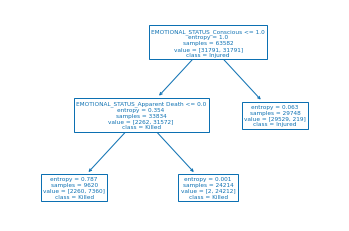

In [29]:
from sklearn import tree

labels = [str(value) for value in labels]
tree.plot_tree(best_model, feature_names=train.columns, class_names=labels)
savefig(f'images/{file_tag}_dt_best_tree.png')

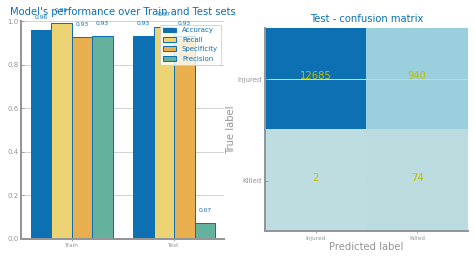

In [30]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)
plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
savefig(f'images/{file_tag}_dt_best.png')
show()

1. feature EMOTIONAL_STATUS_Conscious (0.918998379189654)
2. feature EMOTIONAL_STATUS_Apparent Death (0.08100162081034606)
3. feature PED_ACTION_Working in Roadway (0.0)
4. feature BODILY_INJURY_Elbow-Lower-Arm-Hand (0.0)
5. feature CONTRIBUTING_FACTOR_Traffic Control Device Improper/Non-Working (0.0)
6. feature CONTRIBUTING_FACTOR_Obstruction/Debris (0.0)
7. feature CONTRIBUTING_FACTOR_Listening/Using Headphones (0.0)
8. feature CONTRIBUTING_FACTOR_Lane Marking Improper/Inadequate (0.0)
9. feature CONTRIBUTING_FACTOR_Unsafe Lane Changing (0.0)
10. feature CONTRIBUTING_FACTOR_Brakes Defective (0.0)
11. feature CONTRIBUTING_FACTOR_Oversized Vehicle (0.0)
12. feature CONTRIBUTING_FACTOR_Failure to Keep Right (0.0)
13. feature BODILY_INJURY_Abdomen - Pelvis (0.0)
14. feature BODILY_INJURY_Back (0.0)
15. feature BODILY_INJURY_Chest (0.0)
16. feature BODILY_INJURY_Does Not Apply (0.0)
17. feature BODILY_INJURY_Entire Body (0.0)
18. feature PED_LOCATION_Does Not Apply (0.0)
19. feature BODIL

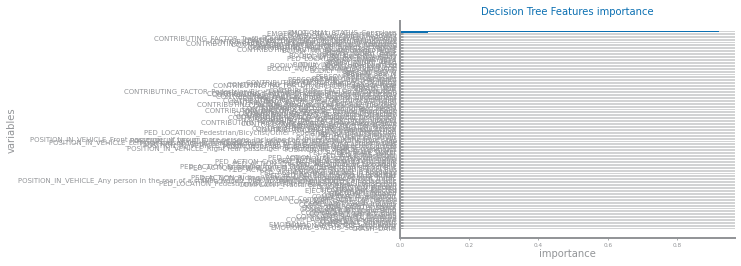

In [31]:
from numpy import argsort, arange
from ds_charts import horizontal_bar_chart
from matplotlib.pyplot import Axes

variables = train.columns
importances = best_model.feature_importances_
indices = argsort(importances)[::-1]
elems = []
imp_values = []
for f in range(len(variables)):
    elems += [variables[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

figure()
horizontal_bar_chart(elems, imp_values, error=None, title='Decision Tree Features importance', xlabel='importance', ylabel='variables')
savefig(f'images/{file_tag}_dt_ranking.png')

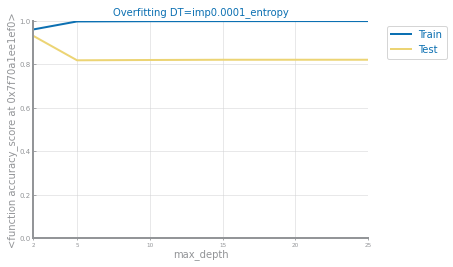

In [32]:
def plot_overfitting_study(xvalues, prd_trn, prd_tst, name, xlabel, ylabel):
    evals = {'Train': prd_trn, 'Test': prd_tst}
    figure()
    multiple_line_chart(xvalues, evals, ax = None, title=f'Overfitting {name}', xlabel=xlabel, ylabel=ylabel, percentage=True)
    savefig(f'images/overfitting_{name}.png')

imp = 0.0001
f = 'entropy'
eval_metric = accuracy_score
y_tst_values = []
y_trn_values = []
for d in max_depths:
    tree = DecisionTreeClassifier(max_depth=d, criterion=f, min_impurity_decrease=imp)
    tree.fit(trnX, trnY)
    prdY = tree.predict(tstX)
    prd_tst_Y = tree.predict(tstX)
    prd_trn_Y = tree.predict(trnX)
    y_tst_values.append(eval_metric(tstY, prd_tst_Y))
    y_trn_values.append(eval_metric(trnY, prd_trn_Y))
plot_overfitting_study(max_depths, y_trn_values, y_tst_values, name=f'DT=imp{imp}_{f}', xlabel='max_depth', ylabel=str(eval_metric))

## Dummified data with scaling

get dataframes:

In [33]:
train: DataFrame = read_csv('data/train_sets/with_scaling.csv')
trnY: ndarray = train.pop(target).values
trnX: ndarray = train.values
labels = unique(trnY)
labels.sort()

test: DataFrame = read_csv('data/test_sets/with_scaling.csv')
tstY: ndarray = test.pop(target).values
tstX: ndarray = test.values

<Figure size 432x288 with 0 Axes>

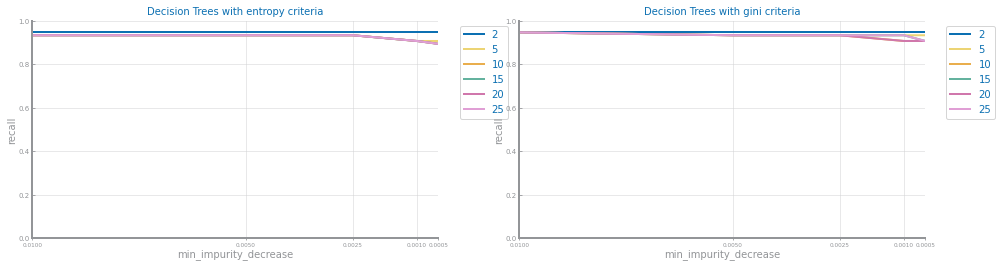

Best results achieved with entropy criteria, depth=2 and min_impurity_decrease=0.01 ==> recall=0.95


In [34]:
min_impurity_decrease = [0.01, 0.005, 0.0025, 0.001, 0.0005]
max_depths = [2, 5, 10, 15, 20, 25]
criteria = ['entropy', 'gini']
best = ('',  0, 0.0)
last_best = 0
best_model = None

figure()
fig, axs = subplots(1, 2, figsize=(16, 4), squeeze=False)
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    for d in max_depths:
        yvalues = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(trnX, trnY)
            prdY = tree.predict(tstX)
            yvalues.append(metrics.recall_score(tstY, prdY, pos_label='Killed'))
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_model = tree

        values[d] = yvalues
    multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title=f'Decision Trees with {f} criteria',
                           xlabel='min_impurity_decrease', ylabel='recall', percentage=True)
savefig(f'images/{file_tag}_scl_dt_study.png')
show()
print('Best results achieved with %s criteria, depth=%d and min_impurity_decrease=%1.2f ==> recall=%1.2f'%(best[0], best[1], best[2], last_best))

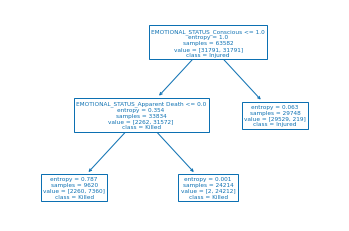

In [35]:
from sklearn import tree

labels = [str(value) for value in labels]
tree.plot_tree(best_model, feature_names=train.columns, class_names=labels)
savefig(f'images/{file_tag}_scl_dt_best_tree.png')

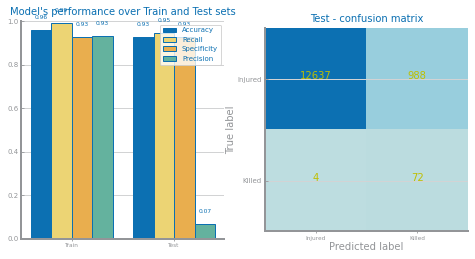

In [36]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)
plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
savefig(f'images/{file_tag}_scl_dt_best.png')
show()

1. feature EMOTIONAL_STATUS_Conscious (0.918998379189654)
2. feature EMOTIONAL_STATUS_Apparent Death (0.08100162081034606)
3. feature PED_ACTION_Working in Roadway (0.0)
4. feature BODILY_INJURY_Elbow-Lower-Arm-Hand (0.0)
5. feature CONTRIBUTING_FACTOR_Traffic Control Device Improper/Non-Working (0.0)
6. feature CONTRIBUTING_FACTOR_Obstruction/Debris (0.0)
7. feature CONTRIBUTING_FACTOR_Listening/Using Headphones (0.0)
8. feature CONTRIBUTING_FACTOR_Lane Marking Improper/Inadequate (0.0)
9. feature CONTRIBUTING_FACTOR_Unsafe Lane Changing (0.0)
10. feature CONTRIBUTING_FACTOR_Brakes Defective (0.0)
11. feature CONTRIBUTING_FACTOR_Oversized Vehicle (0.0)
12. feature CONTRIBUTING_FACTOR_Failure to Keep Right (0.0)
13. feature BODILY_INJURY_Abdomen - Pelvis (0.0)
14. feature BODILY_INJURY_Back (0.0)
15. feature BODILY_INJURY_Chest (0.0)
16. feature BODILY_INJURY_Does Not Apply (0.0)
17. feature BODILY_INJURY_Entire Body (0.0)
18. feature PED_LOCATION_Does Not Apply (0.0)
19. feature BODIL

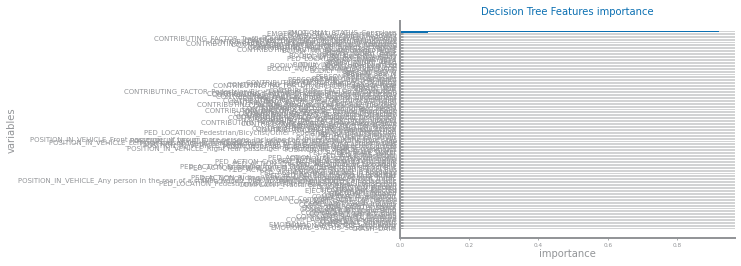

In [37]:
from numpy import argsort, arange
from ds_charts import horizontal_bar_chart
from matplotlib.pyplot import Axes

variables = train.columns
importances = best_model.feature_importances_
indices = argsort(importances)[::-1]
elems = []
imp_values = []
for f in range(len(variables)):
    elems += [variables[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

figure()
horizontal_bar_chart(elems, imp_values, error=None, title='Decision Tree Features importance', xlabel='importance', ylabel='variables')
savefig(f'images/{file_tag}_scl_dt_ranking.png')

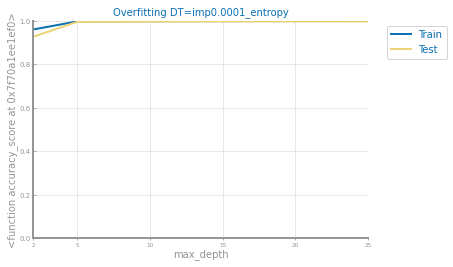

In [38]:

imp = 0.0001
f = 'entropy'
eval_metric = accuracy_score
y_tst_values = []
y_trn_values = []
for d in max_depths:
    tree = DecisionTreeClassifier(max_depth=d, criterion=f, min_impurity_decrease=imp)
    tree.fit(trnX, trnY)
    prdY = tree.predict(tstX)
    prd_tst_Y = tree.predict(tstX)
    prd_trn_Y = tree.predict(trnX)
    y_tst_values.append(eval_metric(tstY, prd_tst_Y))
    y_trn_values.append(eval_metric(trnY, prd_trn_Y))
plot_overfitting_study(max_depths, y_trn_values, y_tst_values, name=f'DT=imp{imp}_{f}', xlabel='max_depth', ylabel=str(eval_metric))